In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_Delhi = pd.read_csv("data/Indian_housing_Delhi_data.csv")
data_Mumbai = pd.read_csv("data/Indian_housing_Mumbai_data.csv")
data_Pune = pd.read_csv("data/Indian_housing_Pune_data.csv")

data_all = [data_Mumbai, data_Pune, data_Delhi]

df = pd.concat(data_all, ignore_index=True)

df.head()

,house_type,house_size,location,city,latitude,longitude,price,currency,numBathrooms,numBalconies,isNegotiable,priceSqFt,verificationDate,description,SecurityDeposit,Status
0,2 BHK Apartment,"1,180 sq ft",Ulwe,Mumbai,18.971046,73.017723,19000,INR,2.0,NaN,NaN,NaN,Posted 2 years ago,It has area of 1180 sqft and is available at a...,No Deposit,Furnished
1,2 BHK Apartment,"1,120 sq ft",Ulwe,Mumbai,18.966377,73.012802,12500,INR,2.0,NaN,NaN,NaN,Posted 2 years ago,Well designed 2 bhk multistorey apartment is a...,No Deposit,Unfurnished
2,2 BHK Apartment,"1,200 sq ft",Panvel,Mumbai,18.965979,73.124649,22000,INR,2.0,NaN,NaN,NaN,Posted a month ago,A spacious 2 bhk multistorey apartment is avai...,No Deposit,Unfurnished
3,2 BHK Apartment,750 sq ft,Kandivali West,Mumbai,19.213598,72.833633,28500,INR,2.0,NaN,NaN,NaN,Posted 3 years ago,It has a built-up area of 750 sqft and is avai...,No Deposit,Unfurnished
4,3 BHK Apartment,"1,400 sq ft",Chembur,Mumbai,19.062933,72.892395,50000,INR,3.0,NaN,NaN,NaN,Posted 3 years ago,The house is semi-furnished. It has power back...,No Deposit,Semi-Furnished


In [3]:
df.shape

(13910, 16)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13910 entries, 0 to 13909
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   house_type        13910 non-null  object 
 1   house_size        13910 non-null  object 
 2   location          13910 non-null  object 
 3   city              13910 non-null  object 
 4   latitude          13910 non-null  float64
 5   longitude         13910 non-null  float64
 6   price             13910 non-null  int64  
 7   currency          13910 non-null  object 
 8   numBathrooms      13854 non-null  float64
 9   numBalconies      5291 non-null   float64
 10  isNegotiable      1276 non-null   object 
 11  priceSqFt         0 non-null      float64
 12  verificationDate  13910 non-null  object 
 13  description       13079 non-null  object 
 14  SecurityDeposit   13910 non-null  object 
 15  Status            13910 non-null  object 
dtypes: float64(5), int64(1), object(10)
memo

In [5]:
df.isna().mean()

house_type          0.000000
house_size          0.000000
location            0.000000
city                0.000000
latitude            0.000000
longitude           0.000000
price               0.000000
currency            0.000000
numBathrooms        0.004026
numBalconies        0.619626
isNegotiable        0.908267
priceSqFt           1.000000
verificationDate    0.000000
description         0.059741
SecurityDeposit     0.000000
Status              0.000000
dtype: float64

In [6]:
# Analysing Missing Values

feature_nan = [feature for feature in df.columns if df[feature].isnull().sum() >0]

for feature in df.columns:
    if df[feature].isnull().sum().mean()>0:
        print(f'The percentage of NaN values in {feature} is: {np.round(df[feature].isnull().mean(),3)} %')

The percentage of NaN values in numBathrooms is: 0.004 %
The percentage of NaN values in numBalconies is: 0.62 %
The percentage of NaN values in isNegotiable is: 0.908 %
The percentage of NaN values in priceSqFt is: 1.0 %
The percentage of NaN values in description is: 0.06 %


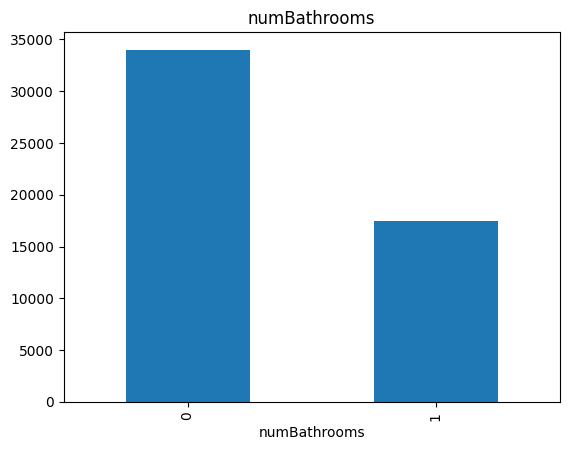

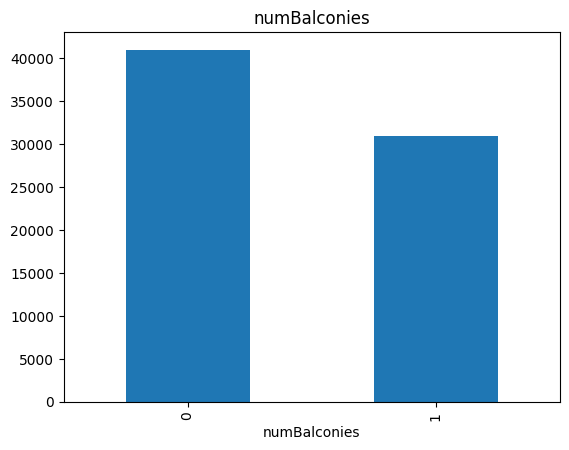

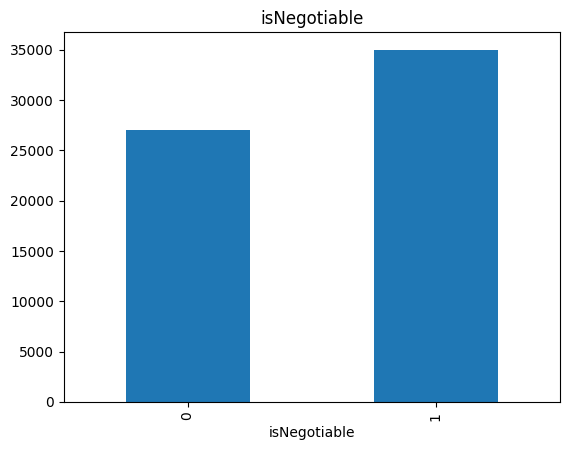

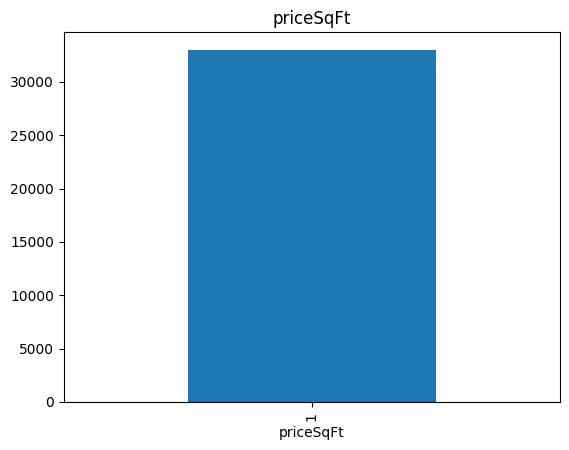

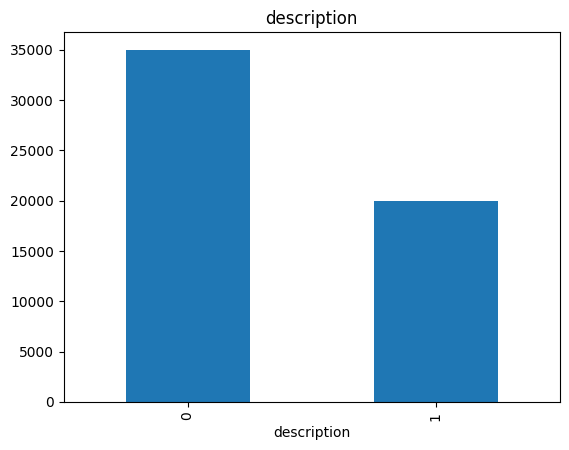

In [7]:
# Analysing Impact of NaN on Rent

for feature in feature_nan:
    data = df.copy()
    data[feature] = np.where(data[feature].isnull(),1,0) #1 for NaN, 0 for non-NaN
    
    data.groupby(feature)['price'].median().plot(kind='bar')
    plt.title(feature)
    plt.show()

In [8]:
## Indetifying categorical and numerical features

num_feature = [feature for feature in df.columns if df[feature].dtype != 'O']
cat_feature = [feature for feature in df.columns if df[feature].dtype == 'O']

In [9]:
df[num_feature].head()

,latitude,longitude,price,numBathrooms,numBalconies,priceSqFt
0,18.971046,73.017723,19000,2.0,NaN,NaN
1,18.966377,73.012802,12500,2.0,NaN,NaN
2,18.965979,73.124649,22000,2.0,NaN,NaN
3,19.213598,72.833633,28500,2.0,NaN,NaN
4,19.062933,72.892395,50000,3.0,NaN,NaN


In [10]:
df[cat_feature].head()

,house_type,house_size,location,city,currency,isNegotiable,verificationDate,description,SecurityDeposit,Status
0,2 BHK Apartment,"1,180 sq ft",Ulwe,Mumbai,INR,NaN,Posted 2 years ago,It has area of 1180 sqft and is available at a...,No Deposit,Furnished
1,2 BHK Apartment,"1,120 sq ft",Ulwe,Mumbai,INR,NaN,Posted 2 years ago,Well designed 2 bhk multistorey apartment is a...,No Deposit,Unfurnished
2,2 BHK Apartment,"1,200 sq ft",Panvel,Mumbai,INR,NaN,Posted a month ago,A spacious 2 bhk multistorey apartment is avai...,No Deposit,Unfurnished
3,2 BHK Apartment,750 sq ft,Kandivali West,Mumbai,INR,NaN,Posted 3 years ago,It has a built-up area of 750 sqft and is avai...,No Deposit,Unfurnished
4,3 BHK Apartment,"1,400 sq ft",Chembur,Mumbai,INR,NaN,Posted 3 years ago,The house is semi-furnished. It has power back...,No Deposit,Semi-Furnished


In [11]:
## Identifying and analysing numerical features that are dicrete or continuous.

discrete = [feature for feature in num_feature if df[feature].nunique() < 25 and feature != 'priceSqFt']
continuous = [feature for feature in num_feature if feature not in discrete and feature != 'priceSqFt' ]
print(f'Number of discrete columns: {len(discrete)}')
print(f'Number of continuous columns: {len(continuous)}')

Number of discrete columns: 2
Number of continuous columns: 3


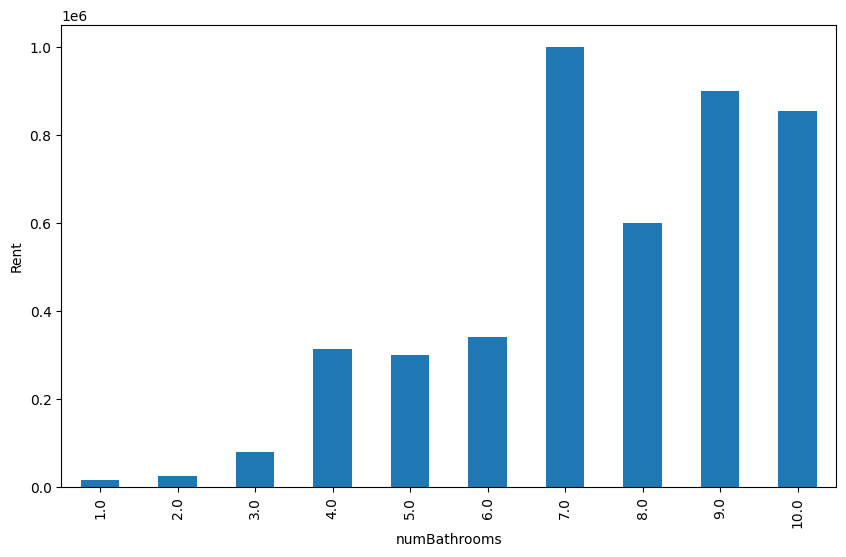

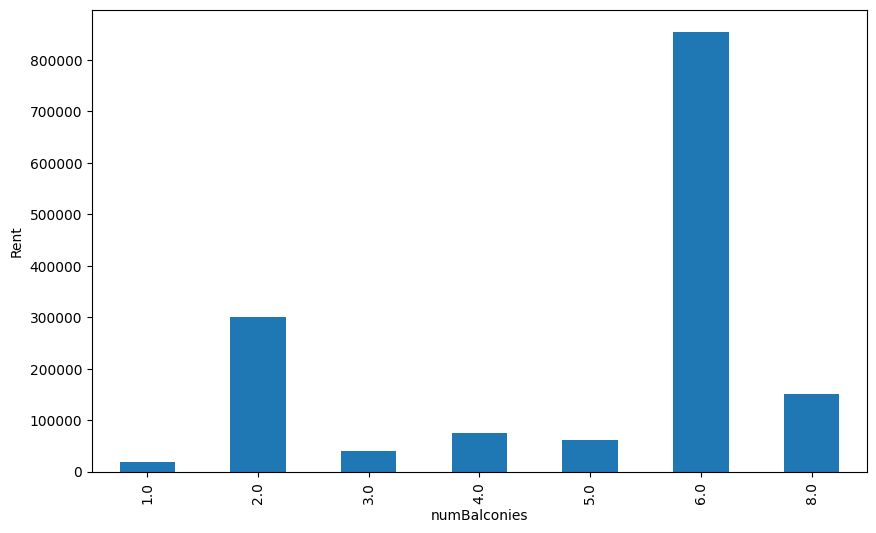

In [12]:
for feature in discrete:
    df.groupby(feature)['price'].median().plot(kind='bar',figsize=(10,6))
    plt.xlabel(feature)
    plt.ylabel('Rent')
    plt.show()

In [13]:
df[(df['numBalconies'] == 8.0) | (df['numBalconies'] == 6.0)]

,house_type,house_size,location,city,latitude,longitude,price,currency,numBathrooms,numBalconies,isNegotiable,priceSqFt,verificationDate,description,SecurityDeposit,Status
2846,6 BHK Villa,"6,000 sq ft",Bandra West,Mumbai,19.060093,72.830307,1176000,INR,7.0,6.0,NaN,NaN,Posted 2 months ago,A 6 bhk property is available for rent in Band...,"60,00,000",Furnished
2848,4 BHK Apartment,"7,000 sq ft",Bandra West,Mumbai,19.060093,72.830307,600000,INR,5.0,6.0,Negotiable,NaN,Posted 2 months ago,The house is furnished. Itâs on 4th floor ou...,"36,00,000",Furnished
2880,6 BHK Villa,"6,000 sq ft",Bandra West,Mumbai,19.060093,72.830307,1176000,INR,7.0,6.0,NaN,NaN,Posted 2 months ago,A 6 bhk property is available for rent in Band...,"60,00,000",Furnished
2882,4 BHK Apartment,"7,000 sq ft",Bandra West,Mumbai,19.060093,72.830307,600000,INR,5.0,6.0,Negotiable,NaN,Posted 2 months ago,The house is furnished. Itâs on 4th floor ou...,"36,00,000",Furnished
11605,5 BHK Villa,"6,521 sq ft",Gulmohar park,Delhi,28.557659,77.212486,401012,INR,4.0,6.0,NaN,NaN,Posted a year ago,Itâs a 5 bhk villa situated in Gulmohar park...,"10,10,202",Unfurnished
12871,9 BHK Independent House,"9,841 sq ft",Shanti Niketan,Delhi,28.577921,77.169373,1010102,INR,9.0,6.0,NaN,NaN,Posted 3 years ago,NaN,"30,10,111",Unfurnished
12874,10 BHK Independent House,"11,221 sq ft",Greater Kailash II,Delhi,28.531740,77.249138,854612,INR,10.0,6.0,NaN,NaN,Posted 3 years ago,NaN,"25,44,612",Unfurnished
13064,6 BHK penthouse,"3,500 sq ft",Sheikh Sarai Village,Delhi,28.534254,77.221458,150000,INR,6.0,8.0,Negotiable,NaN,Posted a month ago,This is a 6 BHK and 6 baths penthouse property...,"3,00,000",Furnished


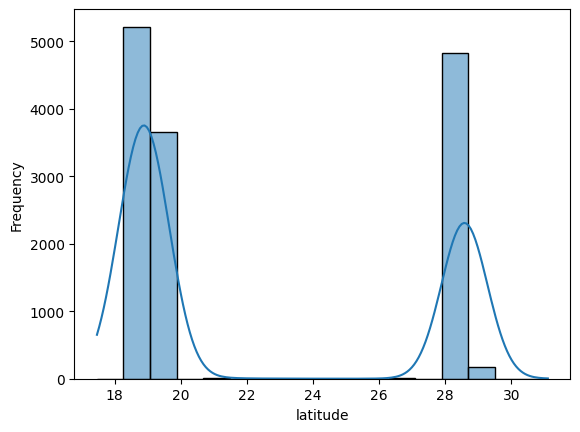

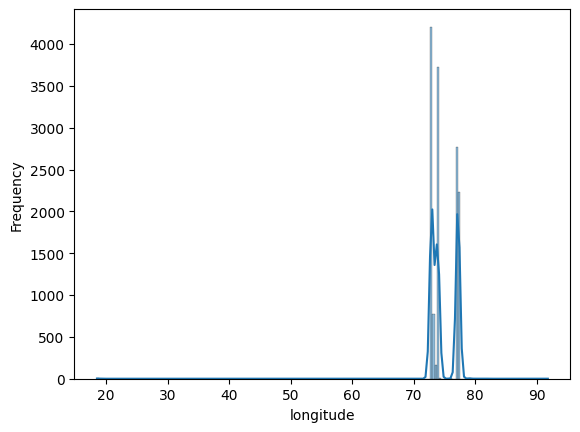

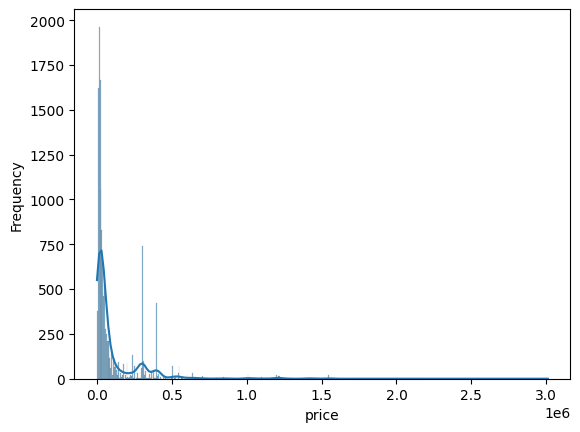

In [14]:
for feature in continuous:
    sns.histplot(data = df,x = feature,kde=True)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

In [15]:
df[['latitude','longitude','price']].corr()

,latitude,longitude,price
latitude,1.000000,0.842016,0.440218
longitude,0.842016,1.000000,0.359846
price,0.440218,0.359846,1.000000


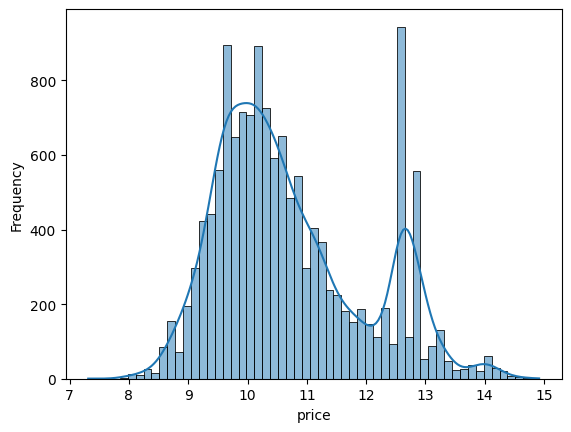

In [16]:
data = df.copy()
data['price'] = np.log(data['price'])
sns.histplot(data = data,x = 'price',kde=True)
plt.xlabel(feature)
plt.ylabel('Frequency')
plt.show()

In [17]:
for feature in cat_feature:
    print(f'Cardinality of {feature} is: {df[feature].nunique()}')

Cardinality of house_type is: 34
Cardinality of house_size is: 1102
Cardinality of location is: 702
Cardinality of city is: 4
Cardinality of currency is: 1
Cardinality of isNegotiable is: 1
Cardinality of verificationDate is: 62
Cardinality of description is: 11331
Cardinality of SecurityDeposit is: 689
Cardinality of Status is: 3


In [18]:
## Outlier Detection

Q1,Q3= df['price'].quantile([0.25,0.75])

IQR = Q3-Q1

ub = Q3 + (1.5 * IQR)
lb = Q1 - (1.5 * IQR)

df[(df['price'] < lb) | (df['price'] > ub )]

,house_type,house_size,location,city,latitude,longitude,price,currency,numBathrooms,numBalconies,isNegotiable,priceSqFt,verificationDate,description,SecurityDeposit,Status
20,4 BHK Apartment,"1,900 sq ft",Juhu,Mumbai,19.113346,72.833580,360000,INR,4.0,NaN,NaN,NaN,Posted a month ago,Itâs a 4 bhk multistorey apartment situated ...,No Deposit,Semi-Furnished
28,3 BHK Apartment,"2,175 sq ft",Parel,Mumbai,18.997904,72.841164,230000,INR,3.0,NaN,NaN,NaN,Posted a month ago,The house is semi-furnished. It is facing nort...,No Deposit,Semi-Furnished
44,3 BHK Apartment,"2,200 sq ft",Mahalaxmi,Mumbai,19.005934,72.829018,280000,INR,2.0,NaN,NaN,NaN,Posted a month ago,It has an area of 2200 sqft with a carpet area...,No Deposit,Semi-Furnished
67,4 BHK Apartment,"3,400 sq ft",Dadar West,Mumbai,19.021095,72.837791,300000,INR,5.0,NaN,NaN,NaN,Posted a year ago,A 4 bhk property is available for rent in Dada...,No Deposit,Semi-Furnished
96,4 BHK Apartment,"4,111 sq ft",Bandra East,Mumbai,19.067099,72.867371,1000000,INR,4.0,NaN,NaN,NaN,Posted a year ago,Itâs a 4 bhk multistorey apartment situated ...,No Deposit,Furnished
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13905,4 BHK Villa,"5,896 sq ft",Sunder Nagar,Delhi,28.618437,76.961784,1022001,INR,4.0,2.0,NaN,NaN,Posted 2 months ago,Its four bhk villa in the super location of De...,"40,10,102",Unfurnished
13906,5 BHK Independent House,"6,521 sq ft",Sunder Nagar,Delhi,28.618437,76.961784,1549181,INR,4.0,2.0,NaN,NaN,Posted 2 months ago,A 5 bhk property is available for rent in Sund...,"54,01,015",Unfurnished
13907,3 BHK Independent Floor,"1,855 sq ft",New Friends Colony,Delhi,28.567051,77.273560,301012,INR,3.0,2.0,NaN,NaN,Posted 2 months ago,Its three bhk builder floor in the super locat...,"18,18,181",Unfurnished
13908,3 BHK Independent Floor,"2,856 sq ft",New Friends Colony,Delhi,28.567051,77.273560,301011,INR,3.0,2.0,NaN,NaN,Posted 2 months ago,Its three bhk builder floor in the super locat...,"10,10,110",Unfurnished


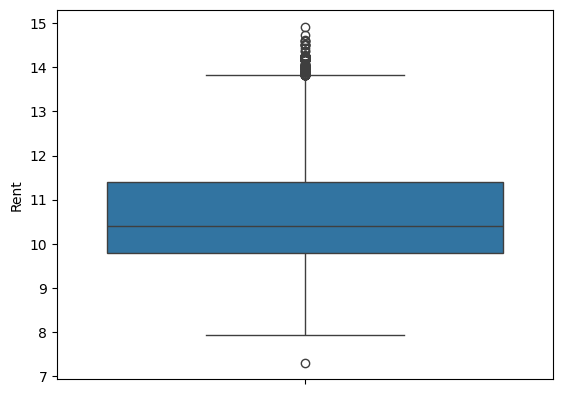

In [19]:
data = df.copy()
data['price'] = np.log(data['price'])
sns.boxplot(data = data,y = 'price')
plt.ylabel('Rent')
plt.show()

In [20]:
#removing unwanted columns

df2 = df.copy()
df2.drop(['priceSqFt','description','currency'], axis=1,inplace=True)
df2.head()

,house_type,house_size,location,city,latitude,longitude,price,numBathrooms,numBalconies,isNegotiable,verificationDate,SecurityDeposit,Status
0,2 BHK Apartment,"1,180 sq ft",Ulwe,Mumbai,18.971046,73.017723,19000,2.0,NaN,NaN,Posted 2 years ago,No Deposit,Furnished
1,2 BHK Apartment,"1,120 sq ft",Ulwe,Mumbai,18.966377,73.012802,12500,2.0,NaN,NaN,Posted 2 years ago,No Deposit,Unfurnished
2,2 BHK Apartment,"1,200 sq ft",Panvel,Mumbai,18.965979,73.124649,22000,2.0,NaN,NaN,Posted a month ago,No Deposit,Unfurnished
3,2 BHK Apartment,750 sq ft,Kandivali West,Mumbai,19.213598,72.833633,28500,2.0,NaN,NaN,Posted 3 years ago,No Deposit,Unfurnished
4,3 BHK Apartment,"1,400 sq ft",Chembur,Mumbai,19.062933,72.892395,50000,3.0,NaN,NaN,Posted 3 years ago,No Deposit,Semi-Furnished


In [21]:
cat_nan = [feature for feature in df2.columns if df2[feature].isnull().sum() >1 and df2[feature].dtype == 'O']

for feature in cat_nan:
    df2[feature+'_'+'nan']=np.where(df2[feature].isnull(),1,0)
    df2[feature].fillna('Missing',inplace=True)

df2.head()

,house_type,house_size,location,city,latitude,longitude,price,numBathrooms,numBalconies,isNegotiable,verificationDate,SecurityDeposit,Status,isNegotiable_nan
0,2 BHK Apartment,"1,180 sq ft",Ulwe,Mumbai,18.971046,73.017723,19000,2.0,NaN,Missing,Posted 2 years ago,No Deposit,Furnished,1
1,2 BHK Apartment,"1,120 sq ft",Ulwe,Mumbai,18.966377,73.012802,12500,2.0,NaN,Missing,Posted 2 years ago,No Deposit,Unfurnished,1
2,2 BHK Apartment,"1,200 sq ft",Panvel,Mumbai,18.965979,73.124649,22000,2.0,NaN,Missing,Posted a month ago,No Deposit,Unfurnished,1
3,2 BHK Apartment,750 sq ft,Kandivali West,Mumbai,19.213598,72.833633,28500,2.0,NaN,Missing,Posted 3 years ago,No Deposit,Unfurnished,1
4,3 BHK Apartment,"1,400 sq ft",Chembur,Mumbai,19.062933,72.892395,50000,3.0,NaN,Missing,Posted 3 years ago,No Deposit,Semi-Furnished,1


In [22]:
## Handling missing values for numerical features

num_nan=[feature for feature in df2.columns if df2[feature].isnull().sum()>1 and df[feature].dtypes!='O']

for feature in num_nan:
    df2[feature+'_'+'nan']=np.where(df2[feature].isnull(),1,0)
    df2[feature].fillna(df2[feature].median(),inplace = True)

df2.head()

,house_type,house_size,location,city,latitude,longitude,price,numBathrooms,numBalconies,isNegotiable,verificationDate,SecurityDeposit,Status,isNegotiable_nan,numBathrooms_nan,numBalconies_nan
0,2 BHK Apartment,"1,180 sq ft",Ulwe,Mumbai,18.971046,73.017723,19000,2.0,2.0,Missing,Posted 2 years ago,No Deposit,Furnished,1,0,1
1,2 BHK Apartment,"1,120 sq ft",Ulwe,Mumbai,18.966377,73.012802,12500,2.0,2.0,Missing,Posted 2 years ago,No Deposit,Unfurnished,1,0,1
2,2 BHK Apartment,"1,200 sq ft",Panvel,Mumbai,18.965979,73.124649,22000,2.0,2.0,Missing,Posted a month ago,No Deposit,Unfurnished,1,0,1
3,2 BHK Apartment,750 sq ft,Kandivali West,Mumbai,19.213598,72.833633,28500,2.0,2.0,Missing,Posted 3 years ago,No Deposit,Unfurnished,1,0,1
4,3 BHK Apartment,"1,400 sq ft",Chembur,Mumbai,19.062933,72.892395,50000,3.0,2.0,Missing,Posted 3 years ago,No Deposit,Semi-Furnished,1,0,1


In [23]:
df2.isnull().sum()

house_type          0
house_size          0
location            0
city                0
latitude            0
longitude           0
price               0
numBathrooms        0
numBalconies        0
isNegotiable        0
verificationDate    0
SecurityDeposit     0
Status              0
isNegotiable_nan    0
numBathrooms_nan    0
numBalconies_nan    0
dtype: int64

In [24]:
data_for_EDA=df.copy(deep=True)

In [25]:
#  Grouping Data by City and Calculating Average Price
city_price_mean = data_for_EDA.groupby('city')['price'].mean().sort_values(ascending=False)
city_price_mean_df = city_price_mean.reset_index()
city_price_mean_df

,city,price
0,Delhi,222173.816000
1,Mumbai,62402.857572
2,Hisar,57000.000000
3,Pune,22085.651407


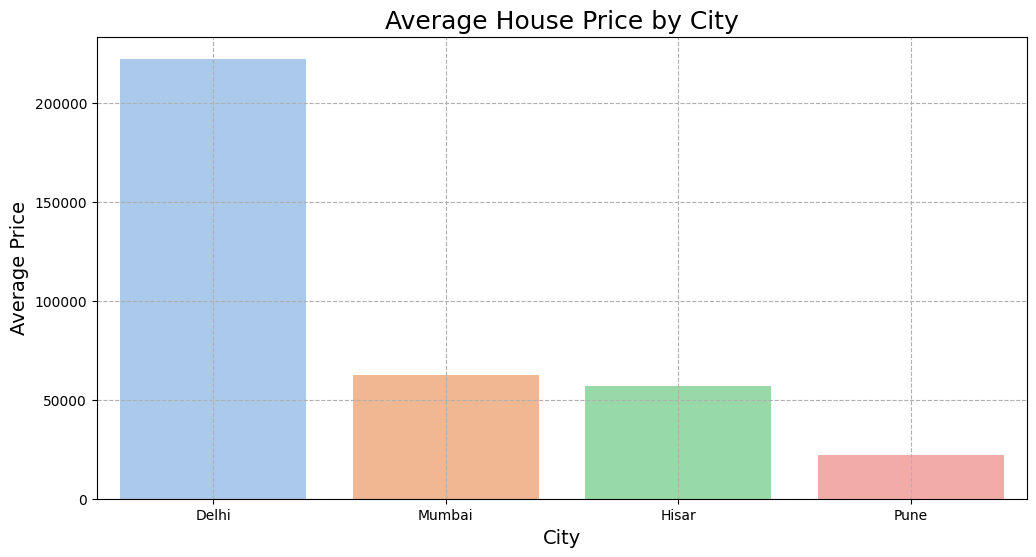

In [26]:
# Average House Price by City (Barplot) with Fixed Palette
plt.figure(figsize=(12, 6))
sns.barplot(
    x='city', 
    y='price', 
    data=city_price_mean_df, 
    palette=sns.color_palette("pastel", len(city_price_mean)),
    hue='city'  # Explicitly assigning the `hue` variable
)
plt.legend([], [], frameon=False)  # Remove the legend created due to `hue`
plt.title('Average House Price by City', fontsize=18)
plt.xlabel('City', fontsize=14)
plt.ylabel('Average Price', fontsize=14)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(linestyle='--')
plt.show()

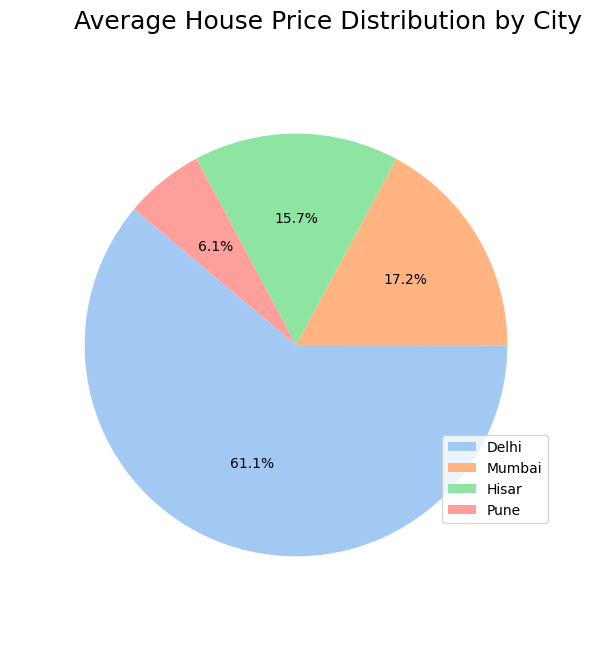

In [27]:
# Average House Price Distribution by City (Pie Chart) with Pastel Colors
city_names = city_price_mean_df['city']
average_prices = city_price_mean_df['price']
colors = sns.color_palette("pastel")[:len(city_names)]  # Generate pastel colors

plt.figure(figsize=(6, 8))
plt.pie(
    average_prices, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=colors  # Apply pastel colors
)
plt.title('        Average House Price Distribution by City', fontsize=18)
plt.axis('equal')
plt.legend(loc='lower left', bbox_to_anchor=(0.8, 0.2), labels=city_names)
plt.show()

In [28]:
# Create house_size_1000 Column that Normalize house sizes into bins of 1000 square feet.
data_for_EDA['house_size_1000'] = (data_for_EDA['house_size']
                                    .str.replace(' sq ft', '')  # Remove ' sq ft'
                                    .str.replace(',', '')       # Remove commas
                                    .astype(int)                # Convert to integers
                                    // 1000                     # Floor division by 1000
                                    ) * 1000                    # Multiply by 1000


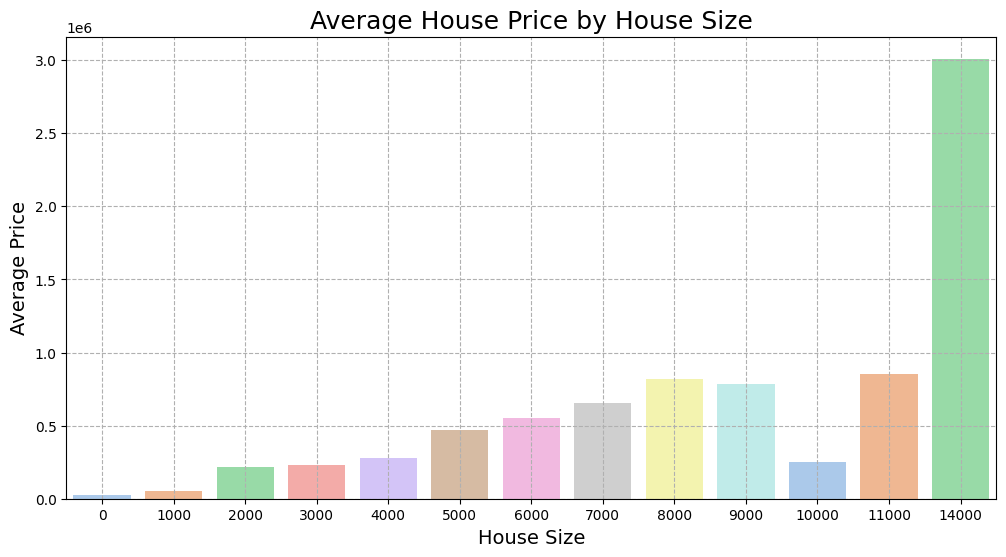

In [29]:
house_size_price_mean = data_for_EDA.groupby('house_size_1000')['price'].mean().sort_values(ascending=False)
house_size_price_mean_df = house_size_price_mean.reset_index()
# Average House Price by house type (Barplot) with Fixed Palette

plt.figure(figsize=(12, 6))
sns.barplot(
    x=house_size_price_mean_df['house_size_1000'],
    y=house_size_price_mean_df['price'], 
    data=house_size_price_mean_df, 
    palette=sns.color_palette("pastel",len(house_size_price_mean_df) ),
    hue=house_size_price_mean_df['house_size_1000']  # Explicitly assigning the `hue` variable
)
plt.legend([], [], frameon=False)  # Remove the legend created due to `hue`
plt.title('Average House Price by House Size', fontsize=18)
plt.xlabel('House Size', fontsize=14)
plt.ylabel('Average Price', fontsize=14)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(linestyle='--')
plt.show()


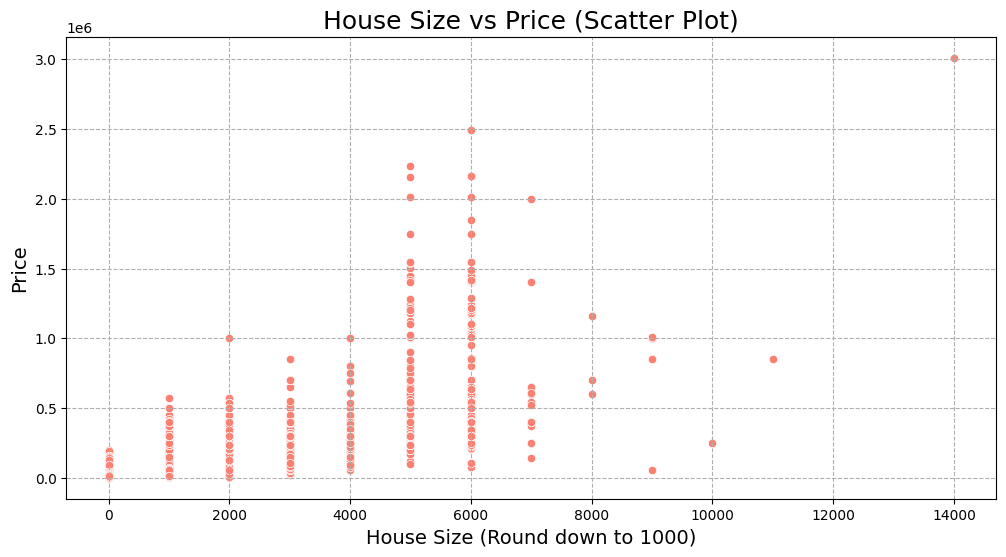

In [30]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='house_size_1000', y='price', data=data_for_EDA, color='salmon')
plt.title('House Size vs Price (Scatter Plot)', fontsize=18)
plt.xlabel('House Size (Round down to 1000)', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.xticks(rotation=0, fontsize=10)  
plt.yticks(fontsize=10)  
plt.grid(linestyle='--') 
plt.show()

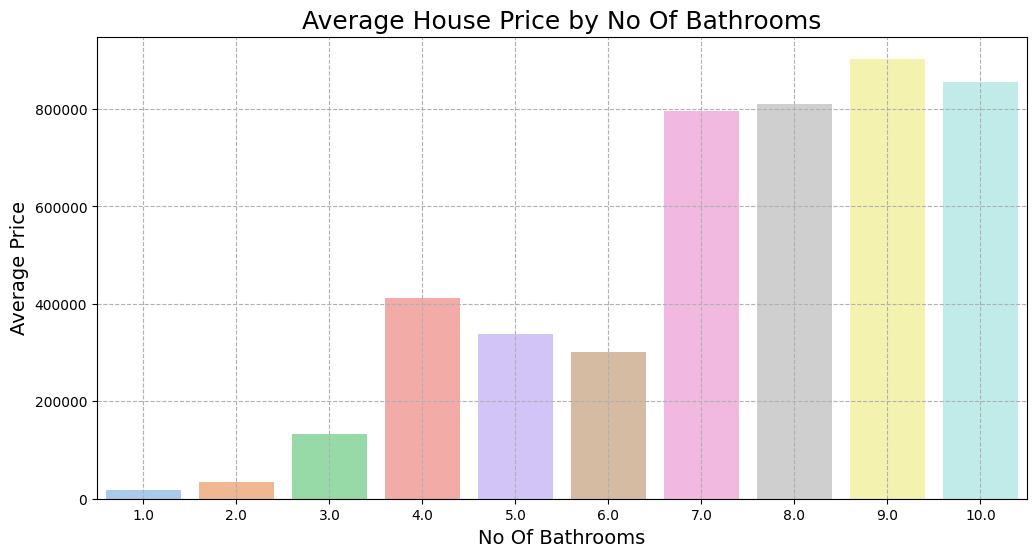

In [31]:
no_of_bathroom_price_mean = data_for_EDA.groupby('numBathrooms')['price'].mean().sort_values(ascending=False)
no_of_bathroom_price_mean_df = no_of_bathroom_price_mean.reset_index()
# Average House Price by house type (Barplot) with Fixed Palette

plt.figure(figsize=(12, 6))
sns.barplot(
    x=no_of_bathroom_price_mean_df['numBathrooms'],
    y=no_of_bathroom_price_mean_df['price'], 
    data=no_of_bathroom_price_mean_df, 
    palette=sns.color_palette("pastel",len(no_of_bathroom_price_mean_df) ),
    hue=no_of_bathroom_price_mean_df['numBathrooms']  # Explicitly assigning the `hue` variable
)
plt.legend([], [], frameon=False)  # Remove the legend created due to `hue`
plt.title('Average House Price by No Of Bathrooms', fontsize=18)
plt.xlabel('No Of Bathrooms', fontsize=14)
plt.ylabel('Average Price', fontsize=14)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(linestyle='--')
plt.show()


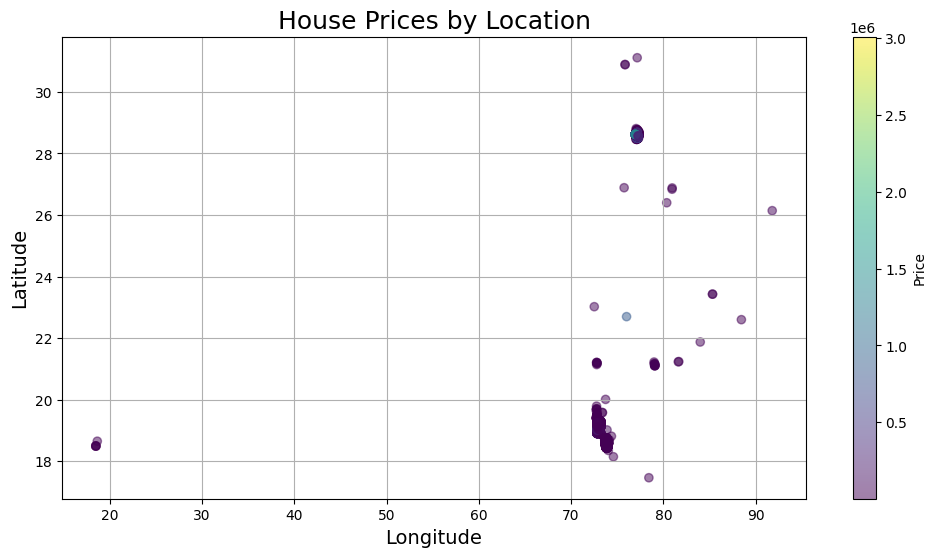

In [32]:
plt.figure(figsize=(12, 6))
plt.scatter(data_for_EDA['longitude'], data_for_EDA['latitude'], c=data_for_EDA['price'], cmap='viridis', alpha=0.5)
plt.colorbar(label='Price')
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.title('House Prices by Location', fontsize=18)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid('--')
plt.show()

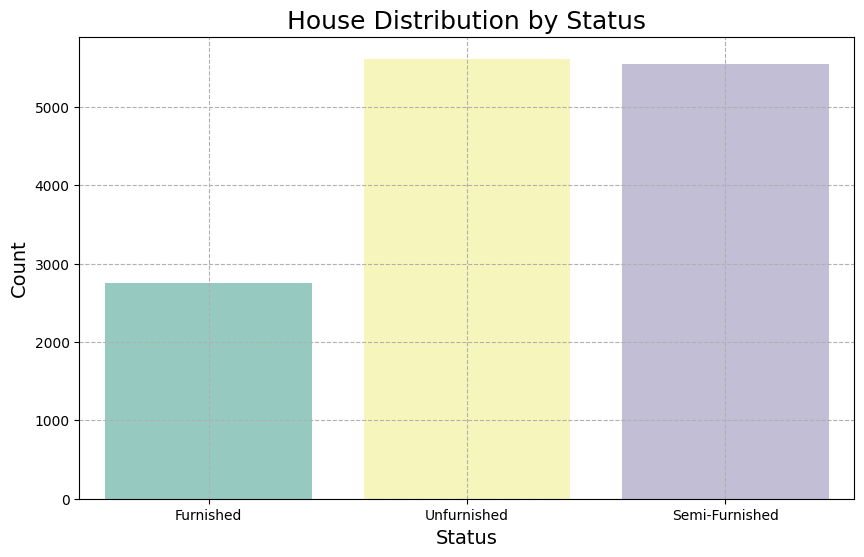

In [33]:
# House Distribution by Status (Countplot)
plt.figure(figsize=(10, 6))
sns.countplot(x='Status', data=data_for_EDA, palette='Set3', hue="Status")
plt.title('House Distribution by Status', fontsize=18)
plt.xlabel('Status', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(linestyle='--')
plt.show()


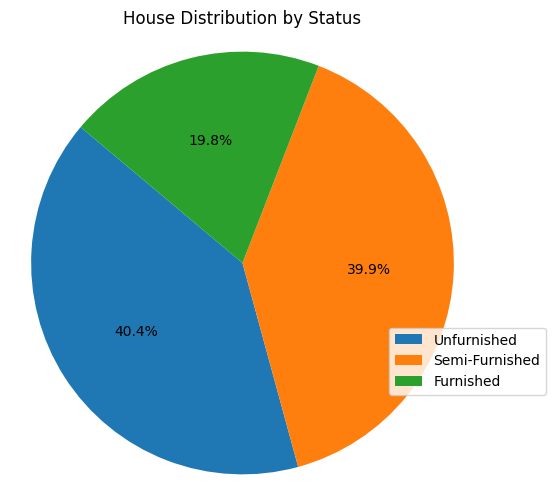

In [34]:

# House Distribution by Status (Pie plot)
status_counts = data_for_EDA['Status'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(status_counts, autopct='%1.1f%%', startangle=140)
plt.title('House Distribution by Status')
plt.axis('equal')
plt.legend(loc='lower left', bbox_to_anchor=(0.8, 0.2),labels=status_counts.index)  
plt.show()

In [35]:
df2['bhk'] = df2['house_type'].apply(lambda x: int(x.split()[0]))
    
df2.head()

,house_type,house_size,location,city,latitude,longitude,price,numBathrooms,numBalconies,isNegotiable,verificationDate,SecurityDeposit,Status,isNegotiable_nan,numBathrooms_nan,numBalconies_nan,bhk
0,2 BHK Apartment,"1,180 sq ft",Ulwe,Mumbai,18.971046,73.017723,19000,2.0,2.0,Missing,Posted 2 years ago,No Deposit,Furnished,1,0,1,2
1,2 BHK Apartment,"1,120 sq ft",Ulwe,Mumbai,18.966377,73.012802,12500,2.0,2.0,Missing,Posted 2 years ago,No Deposit,Unfurnished,1,0,1,2
2,2 BHK Apartment,"1,200 sq ft",Panvel,Mumbai,18.965979,73.124649,22000,2.0,2.0,Missing,Posted a month ago,No Deposit,Unfurnished,1,0,1,2
3,2 BHK Apartment,750 sq ft,Kandivali West,Mumbai,19.213598,72.833633,28500,2.0,2.0,Missing,Posted 3 years ago,No Deposit,Unfurnished,1,0,1,2
4,3 BHK Apartment,"1,400 sq ft",Chembur,Mumbai,19.062933,72.892395,50000,3.0,2.0,Missing,Posted 3 years ago,No Deposit,Semi-Furnished,1,0,1,3


In [36]:
df2['house_type'] = df2['house_type'].apply(lambda x: x.split()[-1])
df2.head()

,house_type,house_size,location,city,latitude,longitude,price,numBathrooms,numBalconies,isNegotiable,verificationDate,SecurityDeposit,Status,isNegotiable_nan,numBathrooms_nan,numBalconies_nan,bhk
0,Apartment,"1,180 sq ft",Ulwe,Mumbai,18.971046,73.017723,19000,2.0,2.0,Missing,Posted 2 years ago,No Deposit,Furnished,1,0,1,2
1,Apartment,"1,120 sq ft",Ulwe,Mumbai,18.966377,73.012802,12500,2.0,2.0,Missing,Posted 2 years ago,No Deposit,Unfurnished,1,0,1,2
2,Apartment,"1,200 sq ft",Panvel,Mumbai,18.965979,73.124649,22000,2.0,2.0,Missing,Posted a month ago,No Deposit,Unfurnished,1,0,1,2
3,Apartment,750 sq ft,Kandivali West,Mumbai,19.213598,72.833633,28500,2.0,2.0,Missing,Posted 3 years ago,No Deposit,Unfurnished,1,0,1,2
4,Apartment,"1,400 sq ft",Chembur,Mumbai,19.062933,72.892395,50000,3.0,2.0,Missing,Posted 3 years ago,No Deposit,Semi-Furnished,1,0,1,3


In [37]:
df2['house_size_sqft'] = df2['house_size'].apply(lambda x: int(x.replace(',','').split()[0]))
    
df2.head()

,house_type,house_size,location,city,latitude,longitude,price,numBathrooms,numBalconies,isNegotiable,verificationDate,SecurityDeposit,Status,isNegotiable_nan,numBathrooms_nan,numBalconies_nan,bhk,house_size_sqft
0,Apartment,"1,180 sq ft",Ulwe,Mumbai,18.971046,73.017723,19000,2.0,2.0,Missing,Posted 2 years ago,No Deposit,Furnished,1,0,1,2,1180
1,Apartment,"1,120 sq ft",Ulwe,Mumbai,18.966377,73.012802,12500,2.0,2.0,Missing,Posted 2 years ago,No Deposit,Unfurnished,1,0,1,2,1120
2,Apartment,"1,200 sq ft",Panvel,Mumbai,18.965979,73.124649,22000,2.0,2.0,Missing,Posted a month ago,No Deposit,Unfurnished,1,0,1,2,1200
3,Apartment,750 sq ft,Kandivali West,Mumbai,19.213598,72.833633,28500,2.0,2.0,Missing,Posted 3 years ago,No Deposit,Unfurnished,1,0,1,2,750
4,Apartment,"1,400 sq ft",Chembur,Mumbai,19.062933,72.892395,50000,3.0,2.0,Missing,Posted 3 years ago,No Deposit,Semi-Furnished,1,0,1,3,1400


In [38]:
df2.drop('house_size',axis=1,inplace=True)

In [39]:
df2.head()

,house_type,location,city,latitude,longitude,price,numBathrooms,numBalconies,isNegotiable,verificationDate,SecurityDeposit,Status,isNegotiable_nan,numBathrooms_nan,numBalconies_nan,bhk,house_size_sqft
0,Apartment,Ulwe,Mumbai,18.971046,73.017723,19000,2.0,2.0,Missing,Posted 2 years ago,No Deposit,Furnished,1,0,1,2,1180
1,Apartment,Ulwe,Mumbai,18.966377,73.012802,12500,2.0,2.0,Missing,Posted 2 years ago,No Deposit,Unfurnished,1,0,1,2,1120
2,Apartment,Panvel,Mumbai,18.965979,73.124649,22000,2.0,2.0,Missing,Posted a month ago,No Deposit,Unfurnished,1,0,1,2,1200
3,Apartment,Kandivali West,Mumbai,19.213598,72.833633,28500,2.0,2.0,Missing,Posted 3 years ago,No Deposit,Unfurnished,1,0,1,2,750
4,Apartment,Chembur,Mumbai,19.062933,72.892395,50000,3.0,2.0,Missing,Posted 3 years ago,No Deposit,Semi-Furnished,1,0,1,3,1400


In [40]:
cat_feature = [feature for feature in df2.columns if df2[feature].dtype == 'O']

for feature in cat_feature:
    label_ordered = df2.groupby(feature)['price'].mean().sort_values().index
    label_ordered = {k:i for i,k in enumerate(label_ordered, 0)}
    df2[feature] = df2[feature].map(label_ordered)
    
df2.head()

,house_type,location,city,latitude,longitude,price,numBathrooms,numBalconies,isNegotiable,verificationDate,SecurityDeposit,Status,isNegotiable_nan,numBathrooms_nan,numBalconies_nan,bhk,house_size_sqft
0,0,222,2,18.971046,73.017723,19000,2.0,2.0,1,30,133,1,1,0,1,2,1180
1,0,222,2,18.966377,73.012802,12500,2.0,2.0,1,30,133,2,1,0,1,2,1120
2,0,248,2,18.965979,73.124649,22000,2.0,2.0,1,47,133,2,1,0,1,2,1200
3,0,465,2,19.213598,72.833633,28500,2.0,2.0,1,32,133,2,1,0,1,2,750
4,0,570,2,19.062933,72.892395,50000,3.0,2.0,1,32,133,0,1,0,1,3,1400


In [41]:
#Normalizing Rent

df2['price'] = np.log(df2['price'])
df2.head()

,house_type,location,city,latitude,longitude,price,numBathrooms,numBalconies,isNegotiable,verificationDate,SecurityDeposit,Status,isNegotiable_nan,numBathrooms_nan,numBalconies_nan,bhk,house_size_sqft
0,0,222,2,18.971046,73.017723,9.852194,2.0,2.0,1,30,133,1,1,0,1,2,1180
1,0,222,2,18.966377,73.012802,9.433484,2.0,2.0,1,30,133,2,1,0,1,2,1120
2,0,248,2,18.965979,73.124649,9.998798,2.0,2.0,1,47,133,2,1,0,1,2,1200
3,0,465,2,19.213598,72.833633,10.257659,2.0,2.0,1,32,133,2,1,0,1,2,750
4,0,570,2,19.062933,72.892395,10.819778,3.0,2.0,1,32,133,0,1,0,1,3,1400


In [42]:
#Scaling the features

feature_scale = [feature for feature in df2.columns if feature != 'price']

scaler = StandardScaler()
scaler.fit(df2[feature_scale])

df_scaled = pd.concat([df2['price'].reset_index(drop=True),pd.DataFrame(scaler.transform(df2[feature_scale]), columns = feature_scale)],axis=1)
df_scaled.head()

,price,house_type,location,city,latitude,longitude,numBathrooms,numBalconies,isNegotiable,verificationDate,SecurityDeposit,Status,isNegotiable_nan,numBathrooms_nan,numBalconies_nan,bhk,house_size_sqft
0,9.852194,-0.568931,-1.271627,0.169242,-0.731636,-0.776007,-0.325313,0.137649,0.317801,-1.080267,-0.207563,-0.005217,0.317801,-0.063578,0.783503,-0.317446,-0.324604
1,9.433484,-0.568931,-1.271627,0.169242,-0.732638,-0.778263,-0.325313,0.137649,0.317801,-1.080267,-0.207563,1.111178,0.317801,-0.063578,0.783503,-0.317446,-0.360475
2,9.998798,-0.568931,-1.124374,0.169242,-0.732724,-0.726989,-0.325313,0.137649,0.317801,0.143443,-0.207563,1.111178,0.317801,-0.063578,0.783503,-0.317446,-0.312646
3,10.257659,-0.568931,0.104620,0.169242,-0.679588,-0.860400,-0.325313,0.137649,0.317801,-0.936301,-0.207563,1.111178,0.317801,-0.063578,0.783503,-0.317446,-0.581683
4,10.819778,-0.568931,0.699294,0.169242,-0.711919,-0.833462,0.674267,0.137649,0.317801,-0.936301,-0.207563,-1.121612,0.317801,-0.063578,0.783503,0.588890,-0.193075


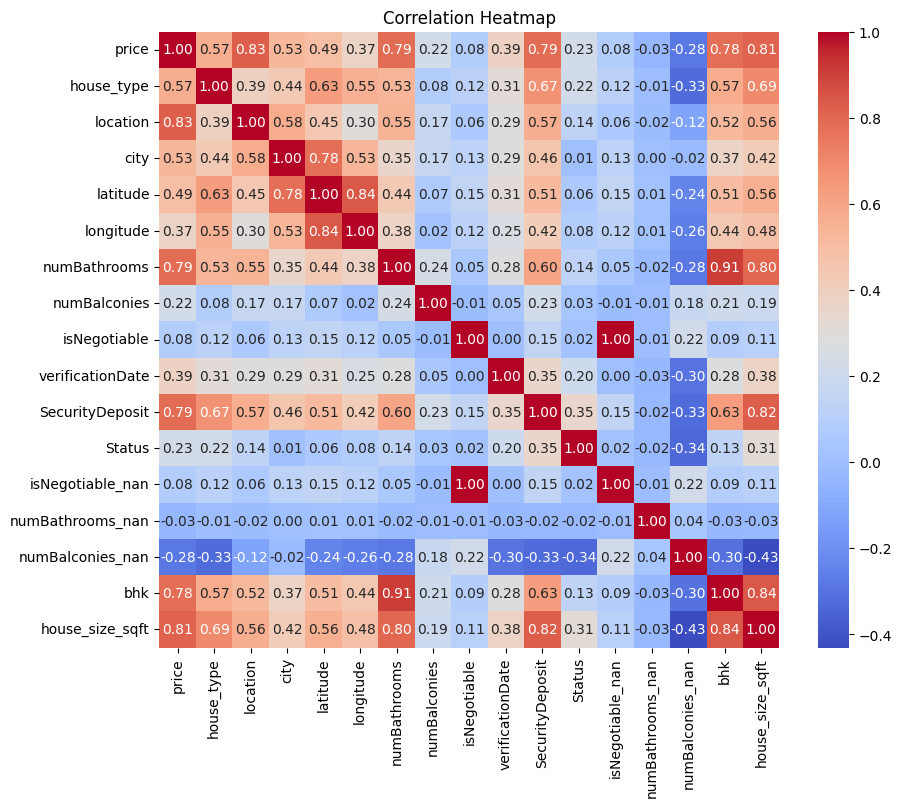

In [43]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_scaled.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [44]:
X = df_scaled.drop('price',axis=1)
y = df_scaled['price']

feature_selection_model = SelectFromModel(Lasso(alpha = 0.05, random_state = 0))
feature_selection_model.fit(X,y)

SelectFromModel(estimator=Lasso(alpha=0.05, random_state=0))

In [45]:
feature_selection_model.get_support()

array([False,  True, False, False, False,  True, False, False,  True,
        True, False, False, False, False,  True,  True])

In [46]:
Selected_Features = X.columns[(feature_selection_model.get_support())]
Selected_Features

Index(['location', 'numBathrooms', 'verificationDate', 'SecurityDeposit',
       'bhk', 'house_size_sqft'],
      dtype='object')

In [47]:
X_final = df_scaled.drop(['latitude','longitude','numBalconies','isNegotiable','isNegotiable_nan','numBathrooms_nan','price'],axis=1)
y_final = df_scaled['price']

In [48]:
X_train,X_test,y_train,y_test = train_test_split(X_final,y_final,test_size=0.20,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((11128, 10), (2782, 10), (11128,), (2782,))

In [49]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [50]:
def model_trainer(X_train,X_test,y_train,y_test):
  models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor()
  }
  model_list = []
  r2_list = []

  for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)
    print('='*35)
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])

    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))  
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
  print('='*35)  
  return model_list,r2_list

In [51]:
model_list,r2_list = model_trainer(X_train,X_test,y_train,y_test)

Linear Regression
Model performance for Test set
- Root Mean Squared Error: 0.3827
- Mean Absolute Error: 0.2892
- R2 Score: 0.9062
Ridge
Model performance for Test set
- Root Mean Squared Error: 0.3827
- Mean Absolute Error: 0.2892
- R2 Score: 0.9062
K-Neighbors Regressor
Model performance for Test set
- Root Mean Squared Error: 0.2744
- Mean Absolute Error: 0.1872
- R2 Score: 0.9518
Decision Tree
Model performance for Test set
- Root Mean Squared Error: 0.2817
- Mean Absolute Error: 0.1689
- R2 Score: 0.9492
Random Forest Regressor
Model performance for Test set
- Root Mean Squared Error: 0.2153
- Mean Absolute Error: 0.1385
- R2 Score: 0.9703
XGBRegressor
Model performance for Test set
- Root Mean Squared Error: 0.2096
- Mean Absolute Error: 0.1448
- R2 Score: 0.9718


In [52]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
5,XGBRegressor,0.971843
4,Random Forest Regressor,0.970304
2,K-Neighbors Regressor,0.951760
3,Decision Tree,0.949158
1,Ridge,0.906176
0,Linear Regression,0.906175


In [53]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score

# Instantiate models
xgb = XGBRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)
knn = KNeighborsRegressor()

# Define parameter grids
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
}

rf_param_grid = {
    'n_estimators': [90,100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

knn_param_grid = {
    'n_neighbors': [3, 5, 10, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2],
}

# GridSearchCV
xgb_grid_search = GridSearchCV(estimator=xgb, param_grid=xgb_param_grid, cv=5, scoring='r2', verbose=1, n_jobs=-1)
rf_grid_search = GridSearchCV(estimator=rf, param_grid=rf_param_grid, cv=5, scoring='r2', verbose=1, n_jobs=-1)
knn_grid_search = GridSearchCV(estimator=knn, param_grid=knn_param_grid, cv=5, scoring='r2', verbose=1, n_jobs=-1)

# RandomizedSearchCV
xgb_random_search = RandomizedSearchCV(estimator=xgb, param_distributions=xgb_param_grid, n_iter=50, cv=5, scoring='r2', verbose=1, random_state=42, n_jobs=-1)
rf_random_search = RandomizedSearchCV(estimator=rf, param_distributions=rf_param_grid, n_iter=50, cv=5, scoring='r2', verbose=1, random_state=42, n_jobs=-1)
knn_random_search = RandomizedSearchCV(estimator=knn, param_distributions=knn_param_grid, n_iter=50, cv=5, scoring='r2', verbose=1, random_state=42, n_jobs=-1)

# Fit the models
print("Fitting GridSearchCV for XGBRegressor...")
xgb_grid_search.fit(X_train, y_train)

print("Fitting RandomizedSearchCV for XGBRegressor...")
xgb_random_search.fit(X_train, y_train)


Fitting GridSearchCV for XGBRegressor...
Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Fitting RandomizedSearchCV for XGBRegressor...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=42, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 1, 5],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [100, 200, 300],
                                        'subsample': [0.8, 1.0]},
                   random_state=42, scoring='r2', verbose=1)

In [54]:
print("Fitting GridSearchCV for RandomForestRegressor...")
rf_grid_search.fit(X_train, y_train)

print("Fitting RandomizedSearchCV for RandomForestRegressor...")
rf_random_search.fit(X_train, y_train)


print("\nRandomForestRegressor GridSearchCV best params:", rf_grid_search.best_params_)
print("RandomForestRegressor GridSearchCV best score:", rf_grid_search.best_score_)
print("RandomForestRegressor RandomizedSearchCV best params:", rf_random_search.best_params_)


Fitting GridSearchCV for RandomForestRegressor...
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Fitting RandomizedSearchCV for RandomForestRegressor...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

RandomForestRegressor GridSearchCV best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
RandomForestRegressor GridSearchCV best score: 0.9673975420017629
RandomForestRegressor RandomizedSearchCV best params: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}


In [55]:
print("Fitting GridSearchCV for KNeighborsRegressor...")
knn_grid_search.fit(X_train, y_train)

print("Fitting RandomizedSearchCV for KNeighborsRegressor...")
knn_random_search.fit(X_train, y_train)

print("\nKNeighborsRegressor GridSearchCV best params:", knn_grid_search.best_params_)
print("KNeighborsRegressor GridSearchCV best score:", knn_grid_search.best_score_)
print("KNeighborsRegressor RandomizedSearchCV best params:", knn_random_search.best_params_)
print("KNeighborsRegressor RandomizedSearchCV best score:", knn_random_search.best_score_)

Fitting GridSearchCV for KNeighborsRegressor...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting RandomizedSearchCV for KNeighborsRegressor...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

KNeighborsRegressor GridSearchCV best params: {'metric': 'manhattan', 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
KNeighborsRegressor GridSearchCV best score: 0.957139364156159
KNeighborsRegressor RandomizedSearchCV best params: {'weights': 'distance', 'p': 1, 'n_neighbors': 10, 'metric': 'manhattan'}
KNeighborsRegressor RandomizedSearchCV best score: 0.957139364156159


In [56]:

# Evaluate and print the best parameters and scores
print("\nBest parameters and scores for each model:\n")
print("XGBRegressor GridSearchCV best params:", xgb_grid_search.best_params_)
print("XGBRegressor GridSearchCV best score:", xgb_grid_search.best_score_)
print("XGBRegressor RandomizedSearchCV best params:", xgb_random_search.best_params_)
print("XGBRegressor RandomizedSearchCV best score:", xgb_random_search.best_score_)


# Test the best models on the test set
print("\nTest set performance:")
print("XGBRegressor (GridSearchCV):", r2_score(y_test, xgb_grid_search.best_estimator_.predict(X_test)))
print("XGBRegressor (RandomizedSearchCV):", r2_score(y_test, xgb_random_search.best_estimator_.predict(X_test)))

print("RandomForestRegressor (GridSearchCV):", r2_score(y_test, rf_grid_search.best_estimator_.predict(X_test)))
print("RandomForestRegressor (RandomizedSearchCV):", r2_score(y_test, rf_random_search.best_estimator_.predict(X_test)))

print("KNeighborsRegressor (GridSearchCV):", r2_score(y_test, knn_grid_search.best_estimator_.predict(X_test)))
print("KNeighborsRegressor (RandomizedSearchCV):", r2_score(y_test, knn_random_search.best_estimator_.predict(X_test)))


Best parameters and scores for each model:

XGBRegressor GridSearchCV best params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
XGBRegressor GridSearchCV best score: 0.9707881669464182
XGBRegressor RandomizedSearchCV best params: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.6}
XGBRegressor RandomizedSearchCV best score: 0.9702271546317082

Test set performance:
XGBRegressor (GridSearchCV): 0.9735859661014191
XGBRegressor (RandomizedSearchCV): 0.9729430624294666
RandomForestRegressor (GridSearchCV): 0.9702643475114965
RandomForestRegressor (RandomizedSearchCV): 0.9702602215010055
KNeighborsRegressor (GridSearchCV): 0.9638639311588133
KNeighborsRegressor (RandomizedSearchCV): 0.9638639311588133
